# Import Packages

In [1]:
import numpy as np
import math as math
import pandas as pd
import random as random
import matplotlib.pyplot as plt
import scikit_posthocs as sp
from scipy.spatial.distance import cdist

from sklearn import metrics
import random

# Import Functions

In [2]:
import importlib.util
import os

def source_directory(directory_path):
    for filename in os.listdir(directory_path):
        if filename.endswith(".py"):
            # Define the module name and path
            module_name = filename[:-3]  # Remove the .py extension
            module_path = os.path.join(directory_path, filename)
            
            # Dynamically load the module
            spec = importlib.util.spec_from_file_location(module_name, module_path)
            module = importlib.util.module_from_spec(spec)
            spec.loader.exec_module(module)
            
            # Inject all functions and variables into the global namespace
            globals().update({name: getattr(module, name) for name in dir(module) if not name.startswith("__")})

# Example usage
source_directory("../functions")


In [3]:
source_directory("/Users/simondn/Documents/RashomonActiveLearning/Code/functions/Main")
source_directory("/Users/simondn/Documents/RashomonActiveLearning/Code/functions/Prediction")
source_directory("/Users/simondn/Documents/RashomonActiveLearning/Code/functions/Selector")

In [4]:
def RunLearningProcedure(df_Train, df_Test, df_Candidate, 
                         SelectorType, selector_args,
                         ModelType, model_args):

    ### Set Up ###
    ErrorVec = []
    SelectedObservationHistory = []

    ### Algorithm
    for i in range(0, len(df_Candidate)):

        ### Prediction Model ###
        Model = ModelType(**model_args)
        if "Model" in selector_args.keys(): selector_args['Model'] = Model            # NOTE: THIS IS NOT DYNAMIC

        CurrentError = TestErrorFunction(Model, df_Test)
        ErrorVec.append(CurrentError)

        ### Sampling Procedure ###
        QueryObservationIndex = SelectorType(**selector_args)
        QueryObservation = df_Candidate.loc[[QueryObservationIndex]] # or should this be iloc
        SelectedObservationHistory.append(QueryObservationIndex)

        # print("Iteration: ", i, "| QueryIndex: ", QueryObservationIndex, "| Inclusion: ", QueryObservationIndex in df_Candidate.index)
        # print(df_Train)
        # print(df_Candidate)
        # print("---")
        
        ### Update Train and Candidate Sets ###
        df_Train = pd.concat([df_Train, QueryObservation])
        df_Candidate = df_Candidate.drop(QueryObservationIndex)

        ### Update selector_args and model_args ###                                     # NOTE: THIS IS NOT DYNAMIC
        if "df_Train" in model_args.keys(): model_args['df_Train'] = df_Train
        if "df_Train" in selector_args.keys(): selector_args['df_Train'] = df_Train
        if "df_Candidate" in selector_args.keys(): selector_args['df_Candidate'] = df_Candidate            

    return ErrorVec, SelectedObservationHistory

# Data 

In [5]:
### Import ###
from plotnine.data import diamonds
df = diamonds.copy()
df.rename(columns={'price': 'Y'}, inplace=True)

### Ordinal Variable ###
# CutMapper = {1:"Fair", 2:"Good", 3:"Very Good", 4:"Premiu ", 5:"Ideal"}
# ColorMapper = {1:"J", 2:"I", 3:"H", 4:"G", 5:"F", 6:"E", 7:"D"}
# ClarityMapper = {1:"I1", 2:"SI1", 3:"SI2", 4:"VS1", 5:"VS2", 6:"VVS1", 7:"VVS2", 8:"IF"}
# df["cut"] = df["cut"].replace(CutMapper)
# df["color"] = df["color"].replace(ColorMapper)
# df["clarity"] = df["clarity"].replace(ClarityMapper)

## Order ##
CutOrder = ['Fair', 'Good', 'Very Good', 'Premium', 'Ideal']
ColorOrder = ['J', 'I', 'H', 'G', 'F', 'E', 'D']
ClarityOrder = ["I1", "SI1", "SI2", "VS1", "VS2", "VVS1", "VVS2", "IF"]

## Reassign ##
df['cut'] = pd.Categorical(df['cut'], categories=CutOrder, ordered=True)
df['color'] = pd.Categorical(df['color'], categories=ColorOrder, ordered=True)
df['clarity'] = pd.Categorical(df['clarity'], categories=ClarityOrder, ordered=True)

# Numbering ##
df['cut'] = df['cut'].cat.codes
df['color'] = df['color'].cat.codes
df['clarity'] = df['clarity'].cat.codes

# Simulation

## Set Up

In [6]:
### Input ###
SimulationN = 50
TestProportion = 0.2
CandidateProportion = 0.8
alpha = 0.01

### Set Up ###
SimulationErrorResultsPassive = []
SimulationErrorResultsGSx = []
SimulationErrorResultsGSy_Test = []
SimulationErrorResultsGSy = []
SimulationErrorResultsiGS = []
SimulationErrorResultsiGS_Test = []

## Simulation

In [7]:
for seed in range(0,SimulationN):

    print("Simulation iter: ", seed)

    ### Set Seed ###
    random.seed(seed)
    np.random.seed(seed)

    ### Set Up ###
    ErrorVec = []
    SelectedObservationHistory = []

    ### Train Test Candidate Split ###
    df_Train, df_Test, df_Candidate = TrainTestCandidateSplit(df, TestProportion, CandidateProportion)

    ### Learning Algorithm ###

    ## Passive ##
    ErrorVecPassive, SelectedObservationHistoryPassive = RunLearningProcedure(df_Train = df_Train, 
                     df_Test = df_Test, 
                     df_Candidate = df_Candidate, 
                     SelectorType = PassiveLearning, 
                     selector_args = {'df_Candidate' : df_Candidate},
                     ModelType = LinearRegressionFunction, 
                     model_args = {'df_Train' : df_Train}
                     )
    
    ## GSx ##
    ErrorVecGSx, SelectedObservationHistoryGSx = RunLearningProcedure(df_Train = df_Train, 
                     df_Test = df_Test, 
                     df_Candidate = df_Candidate, 
                     SelectorType = GSxFunction, 
                     selector_args = {'df_Train' : df_Train,
                                      'df_Candidate' : df_Candidate,
                                      'distance' : 'euclidean'},
                     ModelType = LinearRegressionFunction, 
                     model_args = {'df_Train' : df_Train}
                     )
    
    ## GSy - Training ##
    ErrorVecGSy, SelectedObservationHistoryGSy = RunLearningProcedure(df_Train = df_Train, 
                     df_Test = df_Test, 
                     df_Candidate = df_Candidate, 
                     SelectorType = GSyFunction, 
                     selector_args = {'df_Train' : df_Train,                  #  NOTE: or should this be df_Test
                                      'df_Candidate' : df_Candidate,
                                      'Model': None,
                                      'distance' : 'euclidean'},
                     ModelType = LinearRegressionFunction, 
                     model_args = {'df_Train' : df_Train}
                     )
    
    ## iGS ##
    ErrorVeciGS, SelectedObservationHistoryiGS = RunLearningProcedure(df_Train = df_Train, 
                     df_Test = df_Test, 
                     df_Candidate = df_Candidate, 
                     SelectorType = iGSFunction, 
                     selector_args = {'df_Train' : df_Train,                  #  NOTE: or should this be df_Test
                                      'df_Candidate' : df_Candidate,
                                      'Model': None,
                                      'distance' : 'euclidean'},
                     ModelType = LinearRegressionFunction, 
                     model_args = {'df_Train' : df_Train}
                     )

    ## GSy - Test ##
    ErrorVecGSy_Test, SelectedObservationHistoryGSy_Test = RunLearningProcedure(df_Train = df_Train, 
                     df_Test = df_Test, 
                     df_Candidate = df_Candidate, 
                     SelectorType = GSyFunction, 
                     selector_args = {'df_Train' : df_Test,                  #  NOTE: or should this be df_Test
                                      'df_Candidate' : df_Candidate,
                                      'Model': None,
                                      'distance' : 'euclidean'},
                     ModelType = LinearRegressionFunction, 
                     model_args = {'df_Train' : df_Train}
                     )
    
    ## iGS - Test ##
    ErrorVeciGS_Test, SelectedObservationHistoryiGS_Test = RunLearningProcedure(df_Train = df_Train, 
                     df_Test = df_Test, 
                     df_Candidate = df_Candidate, 
                     SelectorType = iGSFunction, 
                     selector_args = {'df_Train' : df_Test,                  #  NOTE: or should this be df_Test
                                      'df_Candidate' : df_Candidate,
                                      'Model': None,
                                      'distance' : 'euclidean'},
                     ModelType = LinearRegressionFunction, 
                     model_args = {'df_Train' : df_Train}
                     )
    
    ### Save ###
    SimulationErrorResultsPassive.append(ErrorVecPassive)
    SimulationErrorResultsGSx.append(ErrorVecGSx)
    SimulationErrorResultsGSy.append(ErrorVecGSy)
    SimulationErrorResultsGSy_Test.append(ErrorVecGSy_Test)
    SimulationErrorResultsiGS.append(ErrorVeciGS)
    SimulationErrorResultsiGS_Test.append(ErrorVeciGS_Test)


Simulation iter:  0


KeyboardInterrupt: 

In [ ]:
np.savetxt("/Users/simondn/Documents/RashomonActiveLearning/Results/Diamonds_Linear_Passive.csv", 
              SimulationErrorResultsPassive, 
              delimiter=",")
np.savetxt("/Users/simondn/Documents/RashomonActiveLearning/Results/Diamonds_Linear_GSx.csv", 
              SimulationErrorResultsGSx, 
              delimiter=",")
np.savetxt("/Users/simondn/Documents/RashomonActiveLearning/Results/Diamonds_Linear_GSy.csv", 
              SimulationErrorResultsGSy,
              delimiter=",")
np.savetxt("/Users/simondn/Documents/RashomonActiveLearning/Results/Diamonds_Linear_iGS.csv", 
              SimulationErrorResultsiGS, 
              delimiter=",")
np.savetxt("/Users/simondn/Documents/RashomonActiveLearning/Results/Diamonds_Linear_GSy_Test.csv", 
              SimulationErrorResultsGSy_Test, 
              delimiter=",")
np.savetxt("/Users/simondn/Documents/RashomonActiveLearning/Results/Diamonds_Linear_iGS_Test.csv", 
              SimulationErrorResultsiGS_Test, 
              delimiter=",")

# Plots

In [ ]:
### Means ###
SimulationMean_Passive = np.mean(SimulationErrorResultsPassive, axis =0)
SimulationMean_GSx = np.mean(SimulationErrorResultsGSx, axis =0)
SimulationMean_GSy = np.mean(SimulationErrorResultsGSy, axis =0)
SimulationMean_iGS = np.mean(SimulationErrorResultsiGS, axis =0)
SimulationMean_GSy_Test = np.mean(SimulationErrorResultsGSy_Test, axis =0)
SimulationMean_iGS_Test = np.mean(SimulationErrorResultsiGS_Test, axis =0)

### Standard Errors ###
SimulationStd_Passive = np.std(SimulationErrorResultsPassive, axis=0) / np.sqrt(len(SimulationErrorResultsPassive))
SimulationStd_GSx = np.std(SimulationErrorResultsGSx, axis=0) / np.sqrt(len(SimulationErrorResultsGSx))
SimulationStd_GSy = np.std(SimulationErrorResultsGSy, axis=0) / np.sqrt(len(SimulationErrorResultsGSy))
SimulationStd_iGS = np.std(SimulationErrorResultsiGS, axis=0) / np.sqrt(len(SimulationErrorResultsiGS))
SimulationStd_GS_Test = np.std(SimulationErrorResultsGSy_Test, axis=0) / np.sqrt(len(SimulationErrorResultsGSy_Test))
SimulationStd_iGS_Test = np.std(SimulationErrorResultsiGS_Test, axis=0) / np.sqrt(len(SimulationErrorResultsiGS_Test))

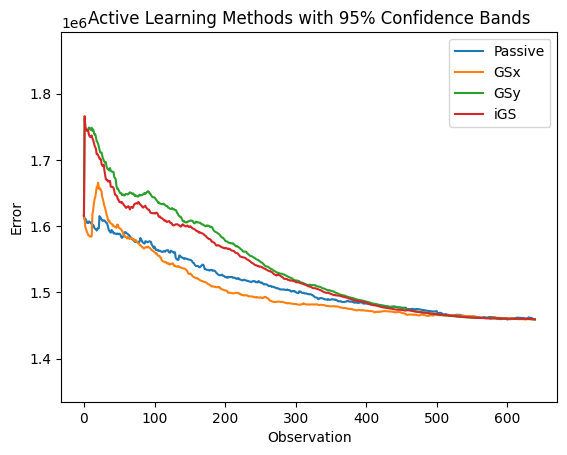

In [ ]:
### Plots ###
# Define the x-axis points
ZScore = 1.65
TransparencyVal = 0
XValues = range(len(SimulationMean_Passive))

# Plot each mean line with confidence bands
plt.plot(XValues, SimulationMean_Passive, label="Passive")
plt.fill_between(XValues,
                 SimulationMean_Passive - ZScore * SimulationStd_Passive,
                 SimulationMean_Passive + ZScore * SimulationStd_Passive,
                 color='blue', alpha = TransparencyVal)

plt.plot(XValues, SimulationMean_GSx, label="GSx")
plt.fill_between(XValues,
                 SimulationMean_GSx - ZScore * SimulationStd_GSx,
                 SimulationMean_GSx + ZScore * SimulationStd_GSx,
                 color='orange', alpha = TransparencyVal)

plt.plot(XValues, SimulationMean_GSy, label="GSy")
plt.fill_between(XValues,
                 SimulationMean_GSy - ZScore * SimulationStd_GSy,
                 SimulationMean_GSy + ZScore * SimulationStd_GSy,
                 color='green', alpha = TransparencyVal)

plt.plot(XValues, SimulationMean_iGS, label="iGS")
plt.fill_between(XValues,
                 SimulationMean_iGS - ZScore * SimulationStd_iGS,
                 SimulationMean_iGS + ZScore * SimulationStd_iGS,
                 color='red', alpha = TransparencyVal)

# Add legend and labels
plt.legend()
plt.xlabel("Observation")
plt.ylabel("Error")
plt.title("Active Learning Methods with 95% Confidence Bands")
plt.show()

# Statistical Testing - Dunn's Procedure

In [12]:
### Set Up ###
SimulationResults = pd.DataFrame({"Passive": SimulationMean_Passive,
                                  "GSx": SimulationMean_GSx,
                                  "GSy": SimulationMean_GSy,
                                  "iGS": SimulationMean_iGS,})
SimulationResults_Long = SimulationResults.melt(var_name="Algorithm", value_name="RMSE")


In [13]:
### Results ###
DunnResults = sp.posthoc_dunn(SimulationResults_Long, val_col='RMSE', group_col='Algorithm', p_adjust='fdr_bh')

print(DunnResults<0.05)

           GSx    GSy  Passive    iGS
GSx      False   True     True   True
GSy       True  False     True  False
Passive   True   True    False   True
iGS       True  False     True  False
